In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nltk
from pprint import pprint
from metrics import multiclass_metrics, binary_metrics
import re

## Load Data


In [2]:
# Start by defining the file relative path of this dataset. 
train_file_name = "../Dataset/Data_train.csv"
val_file_name = "../Dataset/Data_val.csv"
test_file_name = "../Dataset/Data_test.csv"
total_file_name = "../Dataset/Data_FINAL_DATA_totaldata.csv"
sdp_test_name = "../Dataset/SDP_test.csv"

# # Read in the data, use unicode_escape in order to successfully encode the data. 
df = pd.read_csv(total_file_name, encoding= 'unicode_escape')
sdp_df = pd.read_csv(sdp_test_name, encoding= 'unicode_escape')

## Partition Article into Sections


In [3]:
import re

SECTION_KEYWORDS = ['abstract', 'introduction', 'method', 'result', 'discussion', 'reference']

section_keywords_selector = r'(?:%s)' % '|'.join(SECTION_KEYWORDS)

section_selector = (r'\s*?(%s)s?[^a-z]*' % section_keywords_selector) 

section_re = re.compile(section_selector, flags = re.S | re.I)

section_selector

'\\s*?((?:abstract|introduction|method|result|discussion|reference))s?[^a-z]*'

In [4]:
re1 = re.compile(r'-\s+')
re2 = re.compile(r'\s+')
def collapse_lines(text):
    text = re1.sub('', text)
    text = re2.sub(' ', text)
    return text

In [5]:
FULL_TEXT_FOLDER = "../Dataset/full_text_parsed/"

In [6]:
coreid2Article = {}

def process_article(core_id):
    if coreid2Article.get(core_id): return coreid2Article.get(core_id)
    coreid2Article[core_id] = 1

    full_text_file = '%s%s.txt' % (FULL_TEXT_FOLDER, core_id)
    with open(full_text_file, encoding='utf-8') as f:
        full_text = f.read()
    
    # Store the actual text of a section
    sec2Txt = {}
    
    sections = full_text.split('<<<')[1:]
    
    if not sections:
        print('Article %d not labeled!' % core_id)
        return 
    
    for section_text in sections:
        section_name_match_result = section_re.match(section_text)
        if section_name_match_result is None:
            print('Label error for article %d: %s' % (core_id, section_text[:10].replace('\n', ' ')))
            return
        
        section_name = section_name_match_result.group(1).lower()
        if section_name not in sec2Txt:
            sec2Txt[section_name] = ''
        sec2Txt[section_name] += section_text[section_text.lower().find(section_name) + len(section_name) + 1:].strip()
    
    abstract = sec2Txt.get('abstract')
    if abstract:
        idx = abstract.find('>>>')
        if idx > -1:
            sec2Txt['abstract'] = abstract[:idx]
        else:
            print('Article %d doesn\'t have abstract closing' % core_id)
    else:
        print('Article %d doesn\'t have abstract, please double check to make sure' % core_id)
    

    # Remove all new line symbol and also dashes at the end of a line
    for sec in sec2Txt:
        sec2Txt[sec] = collapse_lines(sec2Txt[sec])
        
    sec2Data = {}
    for sec in sec2Txt:
        sec2Data[sec] = {}
        sec2Data[sec]['text'] = sec2Txt[sec]
        sec2Data[sec]['sent'] = nltk.tokenize.sent_tokenize(sec2Txt[sec])
        
    article = {}
    article['sections'] = sec2Data
    article['full_text'] = collapse_lines(full_text)

    coreid2Article[core_id] = article
    return article

# process_article(158977742)
# process_article(82173079)
# process_article(33604192)
# process_article(6503095)

In [7]:
for core_id in tqdm(df['core_id']):
    process_article(core_id)
    
for core_id in tqdm(sdp_df['core_id']):
    process_article(core_id)

100%|██████████| 1000/1000 [00:02<00:00, 459.46it/s]


## Find Abstracts from Partitioned Articles

In [8]:
# process_article(158977742)
def find_abstract_percent(core_id):
    sections = process_article(core_id)['sections']
    abstract_len = len(sections['abstract']['text'])
    tot_len = sum(map(lambda x: len(sections[x]['text']), sections))
    return abstract_len / tot_len

df['abstract'] = [process_article(core_id)['sections']['abstract']['text'] for core_id in df['core_id']]
df['abstract_percent'] = [find_abstract_percent(core_id) for core_id in df['core_id']]
df['abstract_length'] = list(map(len, df['abstract']))

sdp_df['abstract'] = [process_article(core_id)['sections']['abstract']['text'] for core_id in sdp_df['core_id']]
sdp_df['abstract_percent'] = [find_abstract_percent(core_id) for core_id in sdp_df['core_id']]
sdp_df['abstract_length'] = list(map(len, sdp_df['abstract']))

Unnamed: 0  Unnamed: 0.1 unique_id   core_id  \
1669        1669          1669    CC1670  82868732   
1670        1670          1670    CC1671  82868732   
2286        2286          2286    CC2287   4893515   

                                           citing_title    citing_author  \
1669  Grand challenges in the research on soil proce...  Philippe Baveye   
1670  Grand challenges in the research on soil proce...  Philippe Baveye   
2286  No Bel-Robinson Tensor for Quadratic Curvature...          S Deser   

                                            cited_title cited_author  \
1669  Automated statistical method to align 2D chemi...        Hapca   
1670  Moving away from the geostatistical lamppost W...       Baveye   
2286              Gravitation and Relativity in General        Deser   

                                       citation_context  citation_class_label  \
1669  Significant advances related to biological mar...                     0   
1670  An increasingly accepted explanation of the la...                     0   
2286  Subsequently, conserved B were found for arbit...                     0   

      citation_influence_label    set  \
1669                         1  train   
1670                         1  train   
2286                         0  train   

                                               abstract  abstract_percent  \
1669  The exercise of identifying the key challenges...          0.197093   
1670  The exercise of identifying the key challenges...          0.197093   
2286  We attempt to generalize the familiar covarian...          0.101943   

      abstract_length  
1669             6062  
1670             6062  
2286              960

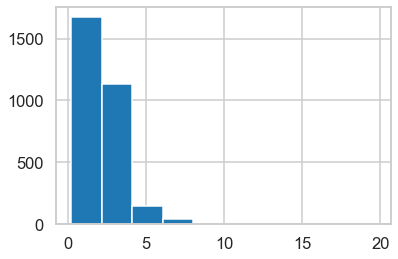

In [9]:
plt.hist(df['abstract_percent'] * 100)
df[(0.1 < df['abstract_percent']) & (df['abstract_percent'] < 0.2)]

In [10]:
df[df['abstract_length'] > 4000].drop_duplicates(subset=['core_id'])

sdp_df[sdp_df['abstract_length'] > 4000].drop_duplicates(subset=['core_id'])

Empty DataFrame
Columns: [unique_id, core_id, citing_title, citing_author, cited_title, cited_author, citation_context, abstract, abstract_percent, abstract_length]
Index: []

## Find Position of Citation Context in Article

In [11]:
idx = 1100

nonword_re = re.compile('[^A-Za-z]+')
def find_position_in_article(idx, df, debug = False):
    entry = df.iloc[idx]
    context = entry['citation_context']
    
    context_set = set(nonword_re.split(context.replace('#AUTHOR_TAG', '')))
    
    sections = process_article(entry['core_id'])['sections']
    
    # As in (sectionName, index)
    search_result = (None, -1)
    best_percentage = 0
    for section in sections:
        for idx, val in enumerate(sections[section]['sent']):
            percentage = len(set(nonword_re.split(val)).intersection(context_set)) / len(context_set)
            if best_percentage < percentage:
                best_percentage = percentage
                search_result = (section, idx)
        if percentage == 1:
            break
    
    if debug:
        print(context)
        print(sections[search_result[0]]['sent'][search_result[1]])
    assert(search_result[1] != -1)
    return search_result

# find_position_in_article(idx, True)

# df[['section', 'sent_idx']] = [find_position_in_article(idx) for idx in tqdm(range(len(df)))]

new_frame = pd.DataFrame([find_position_in_article(idx, df) for idx in tqdm(range(len(df)))], columns=['section', 'sent_idx'])

sdp_new_frame = pd.DataFrame([find_position_in_article(idx, sdp_df) for idx in tqdm(range(len(sdp_df)))], columns=['section', 'sent_idx'])

# [find_position_in_article(11, True), find_position_in_article(12, True)]

100%|██████████| 1000/1000 [00:03<00:00, 255.29it/s]


In [12]:
df[['section', 'sent_idx']] = new_frame

sdp_df[['section', 'sent_idx']] = sdp_new_frame

# Feature 1a: Location of the citation relative to the entire paper

In [13]:
def find_percent_in_article(row):
    core_id, section, sent_idx = row[['core_id', 'section', 'sent_idx']]
    article = process_article(core_id)
    if article['full_text'].find(article['sections'][section]['sent'][sent_idx]) == -1:
        print(core_id)
        return 0
    return (article['full_text'].index(article['sections'][section]['sent'][sent_idx]) / len(article['full_text']))

df['percent_in_article'] = df.apply(find_percent_in_article, axis = 1)

sdp_df['percent_in_article'] = sdp_df.apply(find_percent_in_article, axis = 1)

30619848
30619848


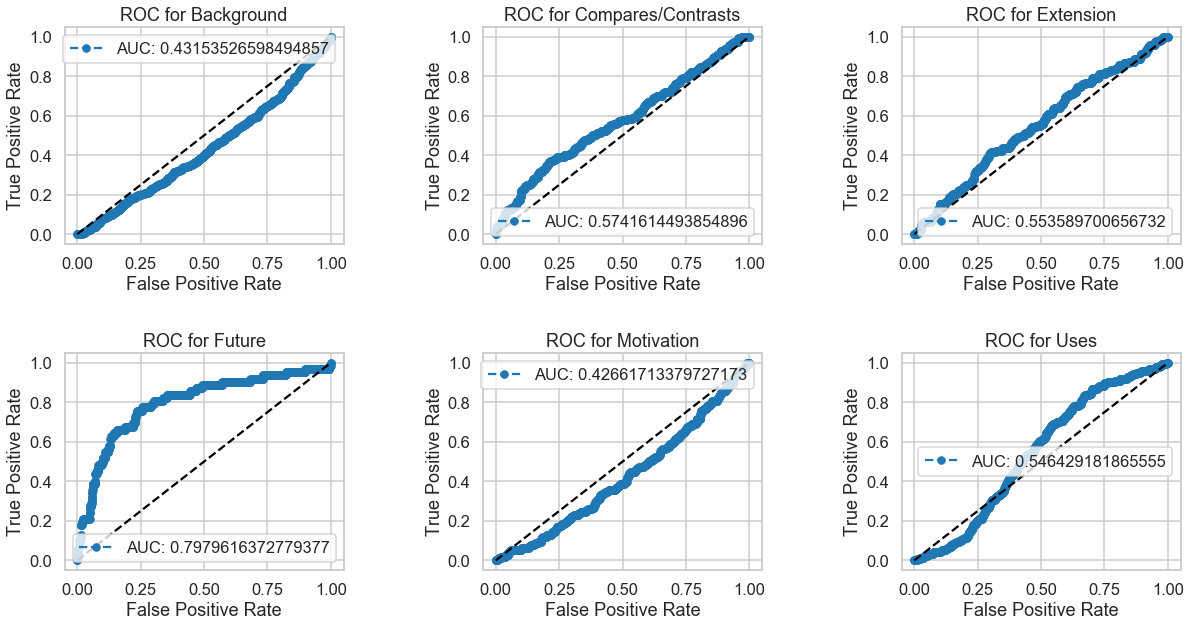

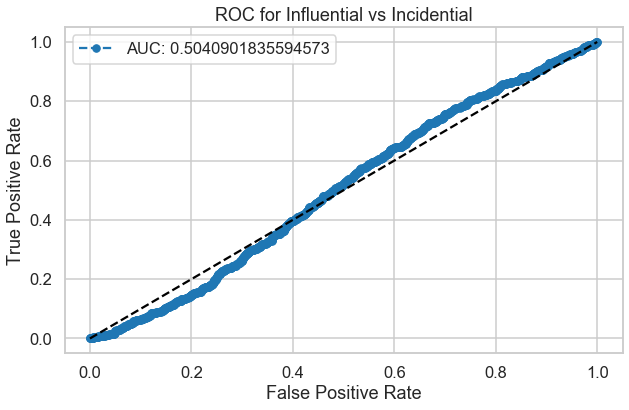

In [14]:
multiclass_metrics(df['citation_class_label'], np.repeat(df['percent_in_article'].to_numpy().reshape(-1, 1), 6, 1))
binary_metrics(df['citation_influence_label'], df['percent_in_article'])

# Feature 1b: Location of the citation relative to the entire paper minus references

In [15]:
def find_percent_in_article_no_ref(row):
    core_id, section, sent_idx = row[['core_id', 'section', 'sent_idx']]
    article = process_article(core_id)
    if article['full_text'].find(article['sections'][section]['sent'][sent_idx]) == -1:
        print(core_id)
        return 0
    if 'reference' not in article['sections']:
        print(core_id)
        return 0
    return (article['full_text'].index(article['sections'][section]['sent'][sent_idx]) 
            / (len(article['full_text']) - len(article['sections']['reference']['text'])))

df['percent_in_article_no_ref'] = df.apply(find_percent_in_article_no_ref, axis = 1)
sdp_df['percent_in_article_no_ref'] = sdp_df.apply(find_percent_in_article_no_ref, axis = 1)

30619848
30619848


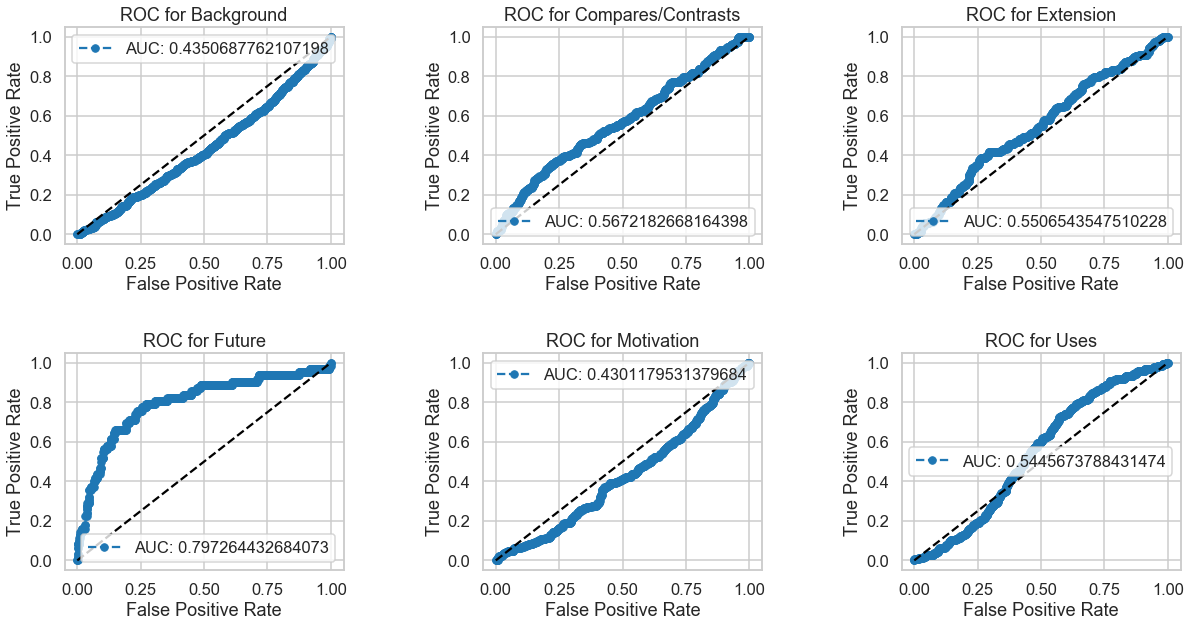

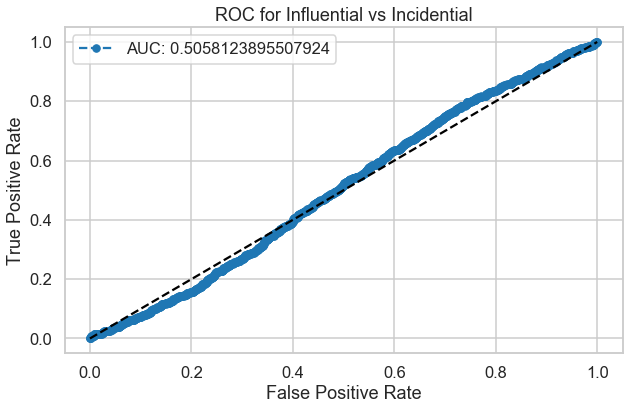

In [16]:
multiclass_metrics(df['citation_class_label'], np.repeat(df['percent_in_article_no_ref'].to_numpy().reshape(-1, 1), 6, 1))
binary_metrics(df['citation_influence_label'], df['percent_in_article_no_ref'])

# Feature 2: Location of the citation relative to the section it's in

In [17]:
def find_percent_in_section(row):
    core_id, section, sent_idx = row[['core_id', 'section', 'sent_idx']]
    article = process_article(core_id)
    return (article['sections'][section]['text'].index(article['sections'][section]['sent'][sent_idx]) / len(article['sections'][section]['text']))

df['percent_in_section'] = df.apply(find_percent_in_section, axis = 1)
sdp_df['percent_in_section'] = sdp_df.apply(find_percent_in_section, axis = 1)

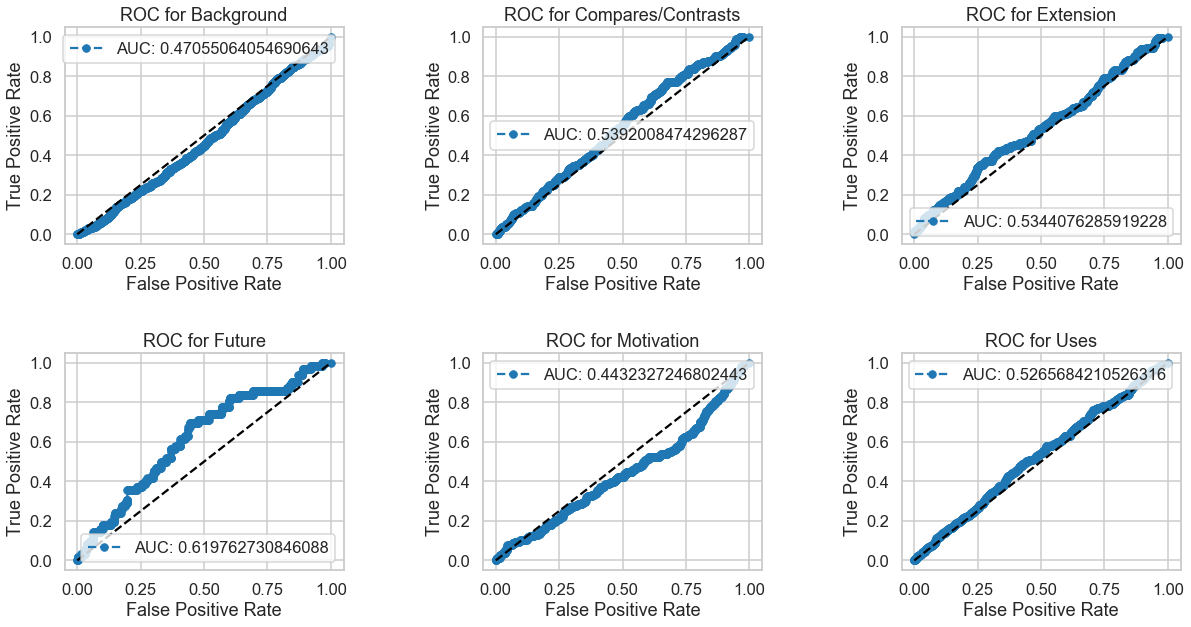

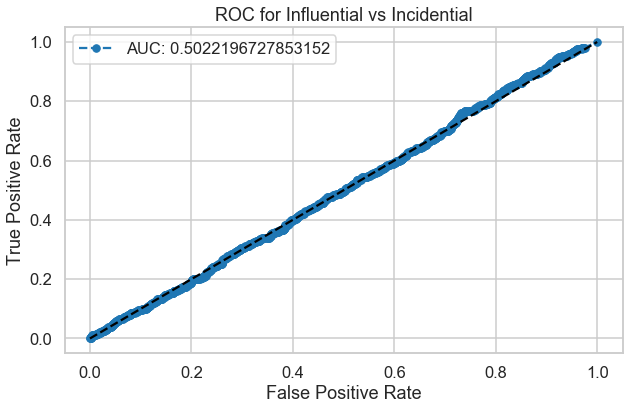

In [18]:
multiclass_metrics(df['citation_class_label'], np.repeat(df['percent_in_section'].to_numpy().reshape(-1, 1), 6, 1))
binary_metrics(df['citation_influence_label'], df['percent_in_section'])

# Feature 3: Number of times the citation appears in the paper

In [19]:
def num_citations(idx, df, section = 'full_text', debug = False):
    core_id = df['core_id'].iloc[idx]
    first_citation = find_percent_in_article_no_ref(df.iloc[0])
    article = process_article(core_id)
    text = ''
    if section == 'full_text':
        text = article['full_text']
    else:
        if section not in article['sections']:
            if debug:
                print("Article {} has no {} section".format(core_id, section))
            return (0, [first_citation])
        text = article['sections'][section]['text']
    
    num_citations = 0
    
    references = article['sections']['reference']['text'].strip()
    abstract = article['sections']['abstract']['text']
    
    # Take out "references" from references text
    if references[0:10].upper() == "REFERENCES":
        references = references[11:]
    elif references[0:9].upper() == "REFERENCE":
        references = references[10:]
    

    # Regex references, cited_title, cited_author
    references = re.sub('ﬁ', 'fi', references)
    references = re.sub('ﬂ', 'fl', references)
    references = re.sub('[-‐−–—“”’\;\:\(\)\,\.\?\'\"\/&]', ' ', references)
    references = re.sub('\s+', ' ', references)
    references = re.sub('[^A-Za-z0-9 ]+', '', references)
    # print(references)
    cited_title = re.sub('[-‐−–—\;\:\(\)\,\.\?\'\"\/&]', ' ', df['cited_title'].iloc[idx])
    cited_title = re.sub('\s+', ' ', cited_title)
    cited_title = re.sub('[^A-Za-z0-9 ]+', '', cited_title)
    cited_author = re.sub('[-‐−–—\;\:\(\)\,\.\?\'\"\/&]', ' ', df['cited_author'].iloc[idx])
    cited_author = re.sub('\s+', ' ', cited_author)
    cited_author = re.sub('[^A-Za-z0-9 ]+', '', cited_author)
    
    #print(references)
    # print(cited_title)
    #print(cited_author)
    
    # Cited author and title should appear in references
    if references.count(cited_title) == 0:
        if debug:
            print("title not in reference error: {}".format(idx))
        return (-1, [first_citation])
    elif references.count(cited_author) == 0:
        if debug:
            print("author not in reference error: {}".format(idx))
        return (-1, [first_citation])
    
    # First check if the paper cites by number or by author name
    # Check if number is after references. Range accounts for (1), [1], 1., etc.
    cite_by_number = True if '1' in references[:2] else False

    if cite_by_number: 
        
        # Find the citation number
        citation_num = -1
        
        # Get locations of cited title in references
        title_pos = [i for i in range(len(references)) if references.startswith(cited_title, i)]
        
        for tp in title_pos:
            ap = references[:tp].rfind(cited_author)
            if ap == -1:
                continue
            
            ref_str = references[0:ap]
            ref_str = re.sub('[^0-9]', ' ', ref_str)
            ref_str_split = ref_str.split(' ')
            for i in range(len(ref_str_split) - 1, -1, -1):
                if len(ref_str_split[i]) == 0:
                    continue
                citation_num = int(ref_str_split[i])
                break
                if references[ap - 2].isdigit():
                    s = ap - 2
                    while s >= 0 and references[s].isdigit():
                        s -= 1
                    citation_num = int(references[s + 1:ap - 1])
                
        pos = []
        
        # Get number of citations for all citations
        cit_dict = {}
        citations_pos = [i for i in range(len(text)) if text.startswith("[", i)]
        cit_w_bracket = False
        
        for cp in citations_pos:
            ind = cp
            while ind < len(text) and text[ind] != "]":
                ind += 1
            cit_str = text[cp + 1:ind]
            
            # print(cit_str)
            
            cit_str_comp = re.sub('[^-–—\,0-9 ]', '', cit_str)
            if cit_str_comp != cit_str:
                continue
            cit_w_bracket = True
            for s in cit_str.split(","):
                s = re.sub(' ', '', s)
                s = re.sub('[-–—]', ' ', s)
                if len(s) == 0:
                    continue
                if len(s.split(' ')) > 1:
                    start = int(s.split(' ')[0])
                    end = int(s.split(' ')[1])
                    for i in range(start, end + 1):
                        if i not in cit_dict:
                            cit_dict[i] = [cp / len(text)]
                        else:
                            cit_dict[i] += [cp / len(text)]
                else:
                    if int(s) not in cit_dict:
                        cit_dict[int(s)] = [cp / len(text)]
                    else:
                        cit_dict[int(s)] += [cp / len(text)]
                        
            # print(cit_dict)
            
        # If not cited by [x], but rather by (x):
        if not cit_w_bracket:
            citations_pos = [i for i in range(len(text)) if text.startswith("(", i)]
        
            for cp in citations_pos:
                ind = cp
                while ind < len(text) and text[ind] != ")":
                    ind += 1
                cit_str = text[cp + 1:ind]

                # print(cit_str)

                cit_str_comp = re.sub('[^-–—\,0-9 ]', '', cit_str)
                if cit_str_comp != cit_str:
                    continue
                for s in cit_str.split(","):
                    s = re.sub(' ', '', s)
                    s = re.sub('[-–—]', ' ', s)
                    if len(s) == 0:
                        continue
                    if len(s.split(' ')) > 1:
                        start = int(s.split(' ')[0])
                        end = int(s.split(' ')[1])
                        for i in range(start, end + 1):
                            if i not in cit_dict:
                                cit_dict[i] = [cp / len(text)]
                            else:
                                cit_dict[i] += [cp / len(text)]
                    else:
                        if int(s) not in cit_dict:
                            cit_dict[int(s)] = [cp / len(text)]
                        else:
                            cit_dict[int(s)] += [cp / len(text)]

                # print(cit_dict)
        #print(cit_w_bracket)
        #print(citation_num)
        # Count the number of citations
        if citation_num != -1:
            if citation_num not in cit_dict:
                if debug:
                    print("Citation not found: {}".format(idx))
                return(-2, [first_citation])
            num_citations = len(cit_dict[citation_num])
            pos = cit_dict[citation_num]
            
            if num_citations == 0:
                if debug:
                    print("Number of citations = 0: {}".format(idx))
                return (num_citations, [first_citation])
            return (num_citations, pos)
        
        else:
            if debug:
                print("Cannot find citation number: {}".format(idx))
            return (-2, [first_citation])

    else:
    
        # Find the year
        year = ""
            
        # Get locations of cited author in references
        author_pos = [i for i in range(len(references)) if references.startswith(cited_author, i)]
        
        for ap in author_pos:
            tp = references[ap:].find(cited_title)
            if tp == -1 or tp > 300:
                continue
            year = re.sub('[^0-9]+', '', references[ap + tp - 7:ap + tp])
            flag = True
            
            if year == "":
                flag = False
                # Year would be at the end of the citation, instead of between author and title.
                year_possibilities = [s for s in re.findall('[0-9]+', references[ap + tp:min(len(references),ap + tp + 300)])]
                
                # print(year_possibilities)
                
                for y in year_possibilities:
                    if int(y) > 1700 and int(y) < 2022:
                        year = y
                        break
                
            # print("Testing: no number citations, idx = {}, year = {}".format(idx, year))
            
            if int(year) > 1700 and int(year) < 2022:
                # Check if year is unique. (Example: Smith (2016a))
                year_ind = references[ap:ap + tp].find(year)
                if references[ap + year_ind + 4].isalpha() and flag:
                    year += references[ap + year_ind + 4]
                break
                
        # Count the number of citations
        if year != "":
            
            # print(year)
            
            # Regex full text 
            text = re.sub('-', ' ', text)
            text = re.sub('[^A-Za-z0-9 ]+', '', text)
            
            # Get positions of cited_author
            pos = [i for i in range(len(text)) if text.startswith(cited_author, i)]
            
            valid = []
            
            for p in pos:
                # Check if date following author is correct
                while p < len(text) and not text[p].isdigit():
                    p += 1
                if text[p:p + len(year)] == year:
                    valid.append(p / (len(text) - len(abstract)))
                    num_citations += 1
            
            if num_citations == 0:
                if debug:
                    print("Num citations = 0: {}".format(idx))
                return (num_citations, [first_citation])
            
            return (num_citations, valid)
        
        else:
            # Debug
            if debug:
                print("Year not found error: {}".format(idx))
            return (-2, [first_citation])

### Debug num_citations

In [20]:
title_author_not_found = []
num_year_not_found = []
zero_citations = []
faulty_core_ids = [81719097, 54847651, 2188336, 16246214, 37342138, 42633036, 46115365, 211327317]
num_in_bad_ci = 0
'''
for idx in df.index:
    core_id = df['core_id'].iloc[idx]
    if core_id in faulty_core_ids:
        num_in_bad_ci += 1
        continue
    nums = num_citations(idx, df, debug = True)[0]
    if nums == 0:
        zero_citations.append(idx)
    elif nums == -1:
        title_author_not_found.append(idx)
    elif nums == -2:
        num_year_not_found.append(idx)
'''
        
for idx in sdp_df.index:
    core_id = sdp_df['core_id'].iloc[idx]
    if core_id in faulty_core_ids:
        num_in_bad_ci += 1
        continue
    nums = num_citations(idx, sdp_df, debug = True)[0]
    if nums == 0:
        zero_citations.append(idx)
    elif nums == -1:
        title_author_not_found.append(idx)
    elif nums == -2:
        num_year_not_found.append(idx)

In [21]:
num_citations(969, sdp_df, debug = True)[0]

1

In [22]:
print(len(title_author_not_found), len(num_year_not_found), len(zero_citations), num_in_bad_ci)

0 0 0 25


### Faulty core_ids:

1. 81719097 (wrong core_id)
2. CC1029-1054, CC1380-1381 don't appear in core_id 54847651
3. 2188336 (cited by number without [])
4. 16246214 (cited by number without [])
5. 37342138 (cited by number without [])
6. 42633036 (cited by number without [])
7. 46115365 (doesn't appear in paper)

SDP Test:
1. 211327317 (not the correct paper)

In [23]:
num_cit = []
for idx in tqdm(df.index):
    core_id = df['core_id'].iloc[idx]
    num_cit.append(max(num_citations(idx, df)[0], 1))
    
df['num_cit_in_paper'] = num_cit

sdp_num_cit = []
for idx in tqdm(sdp_df.index):
    core_id = sdp_df['core_id'].iloc[idx]
    sdp_num_cit.append(max(num_citations(idx, sdp_df)[0], 1))
    
sdp_df['num_cit_in_paper'] = sdp_num_cit

100%|██████████| 1000/1000 [00:15<00:00, 63.89it/s]


Text(0.5, 1.0, 'Influence problem histogram')

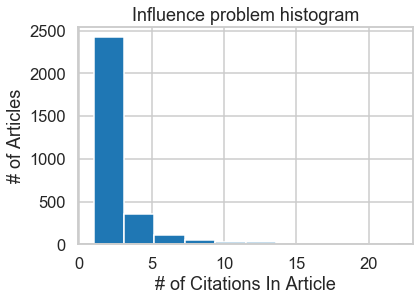

In [24]:
plt.hist(np.asarray(num_cit))
plt.xlabel("# of Citations In Article")
plt.ylabel("# of Articles")
plt.title("Influence problem histogram")

Text(0.5, 1.0, 'Influence problem correlation plot')

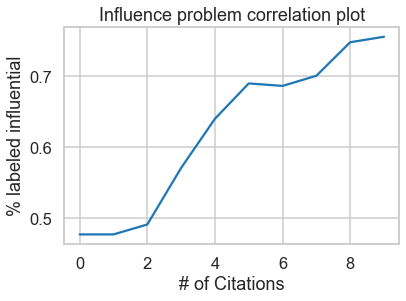

In [25]:
x = [0,1,2,3,4,5,6,7,8,9]
y = []
for xi in range(10):
    cnt = 0
    bin_num_cit = []
    for i in range(len(df)):
        if num_cit[i] >= xi:
            bin_num_cit.append(1)
            if df['citation_influence_label'].iloc[i] == 1:
                cnt += 1
        else:
            bin_num_cit.append(0)
    y.append(cnt / np.sum(bin_num_cit))

plt.plot(x, y)
plt.xlabel("# of Citations")
plt.ylabel("% labeled influential")
plt.title("Influence problem correlation plot")

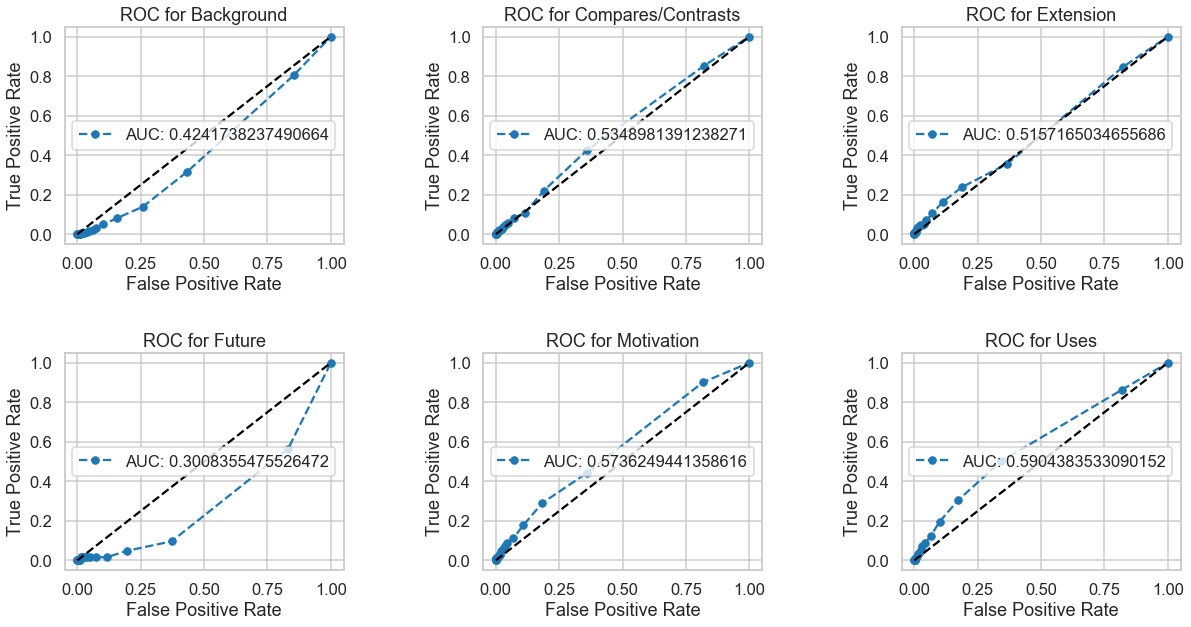

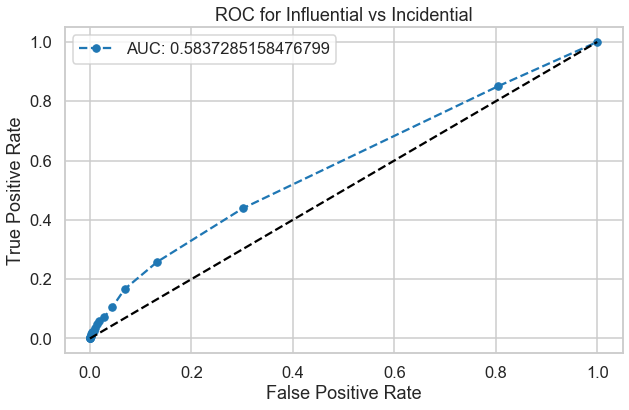

In [26]:
multiclass_metrics(df['citation_class_label'], np.repeat(np.array(num_cit).reshape(-1, 1), 6, 1))
binary_metrics(df['citation_influence_label'], num_cit)

### Confusion matrix with binary version of feature

In [27]:
num_cit_ge4 = []
for idx in df.index:
    if df['num_cit_in_paper'].iloc[idx] >= 4:
        num_cit_ge4.append(1)
    else:
        num_cit_ge4.append(0)

Text(22.5, 0.5, 'Influence')

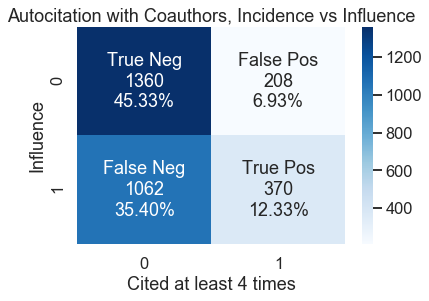

In [28]:
from scipy.stats.stats import pearsonr
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure()
plt.title("Autocitation with Coauthors, Incidence vs Influence")

cf_matrix = confusion_matrix(df["citation_influence_label"].values, num_cit_ge4)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel("Cited at least 4 times")
plt.ylabel("Influence")

### Training a RF Classifier for this feature

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

traindf= df.loc[df["set"]=="train"]

parameters = {
    'n_estimators': [10,50,100],
    'max_depth': [None, 5,10,50,100],
    'ccp_alpha': [0.0, 0.5, 1.0]
}

rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, scoring="f1_macro")

X_train = traindf["num_cit_in_paper"].values.reshape((-1,1))
y_true = traindf["citation_influence_label"].values#.reshape((-1,1))
print(y_true.shape)
print(X_train.shape)
# clf.fit(X_train, y_true)
clf.fit(df['num_cit_in_paper'].values.reshape((-1,1)), df['citation_influence_label'].values)

(2310,)
(2310, 1)


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [0.0, 0.5, 1.0],
                         'max_depth': [None, 5, 10, 50, 100],
                         'n_estimators': [10, 50, 100]},
             scoring='f1_macro')

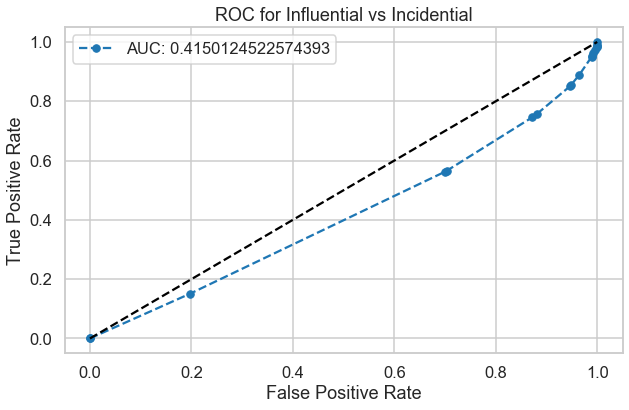

In [30]:
testdf = df.loc[df["set"] == "test"]
# y_test = clf.predict_proba(testdf["num_cit_in_paper"].values.reshape((-1, 1)))
# y_true = testdf["citation_influence_label"].values.reshape((-1,1))
y_test = clf.predict_proba(df['num_cit_in_paper'].values.reshape((-1,1)))
binary_metrics(df['citation_influence_label'].values.reshape((-1,1)), y_test[:,0])

# Feature 4: Number of times citation appears in each section

In [31]:
for section in ['introduction', 'method', 'result', 'discussion']:
    num_cit = []
    for idx in tqdm(df.index):
        core_id = df['core_id'].iloc[idx]
        num_cit.append(max(num_citations(idx, df, section)[0], 0))
    df['num_cit_in_{}'.format(section)] = num_cit
    
    sdp_num_cit = []
    for idx in tqdm(sdp_df.index):
        core_id = sdp_df['core_id'].iloc[idx]
        sdp_num_cit.append(max(num_citations(idx, sdp_df, section)[0], 0))
    sdp_df['num_cit_in_{}'.format(section)] = sdp_num_cit

100%|██████████| 1000/1000 [00:06<00:00, 160.91it/s]


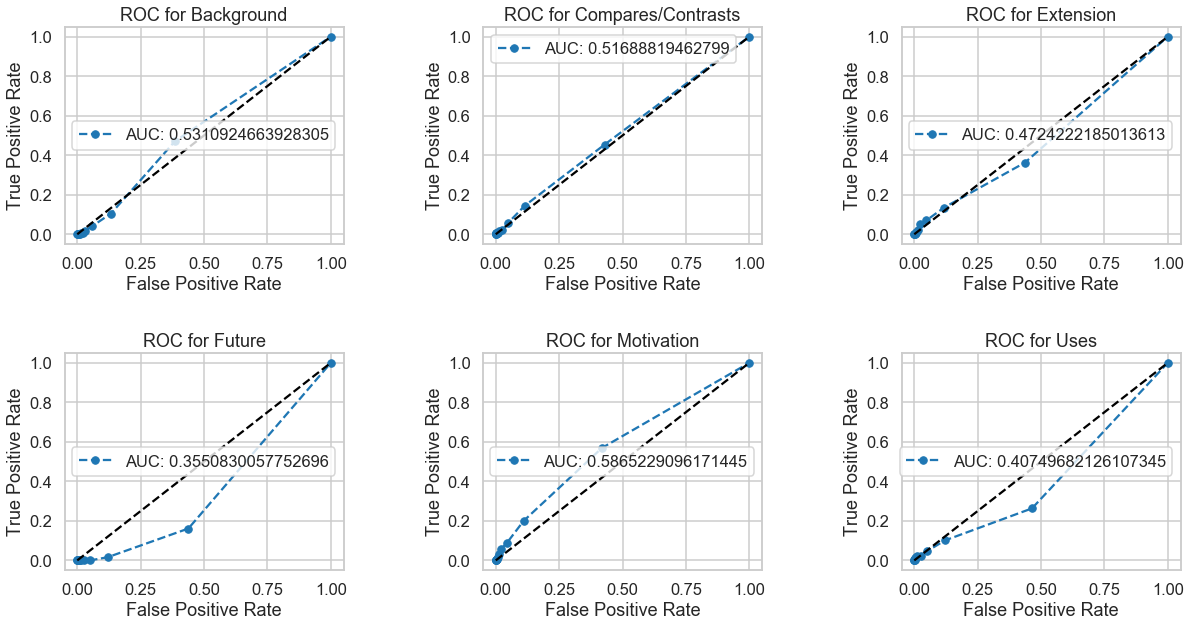

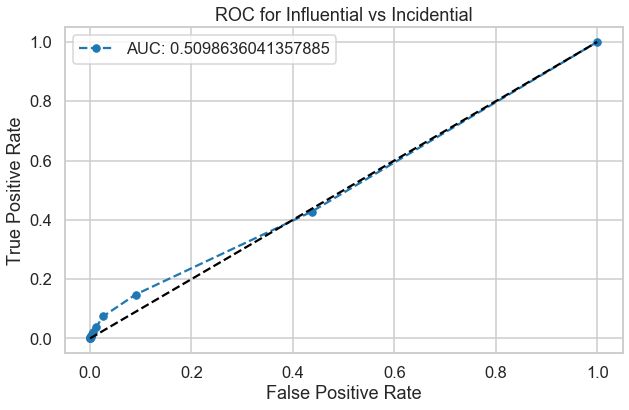

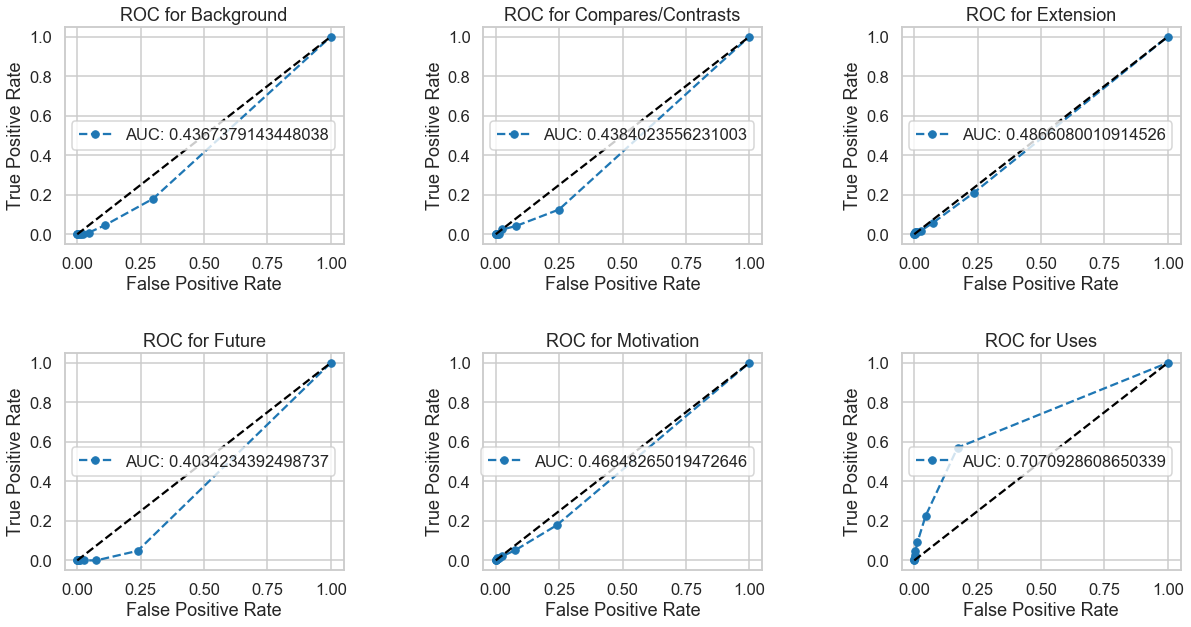

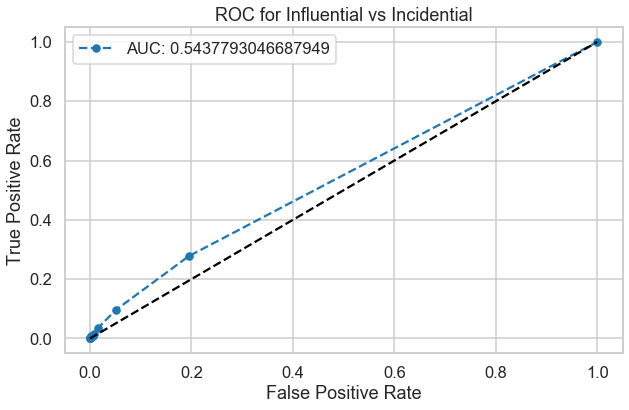

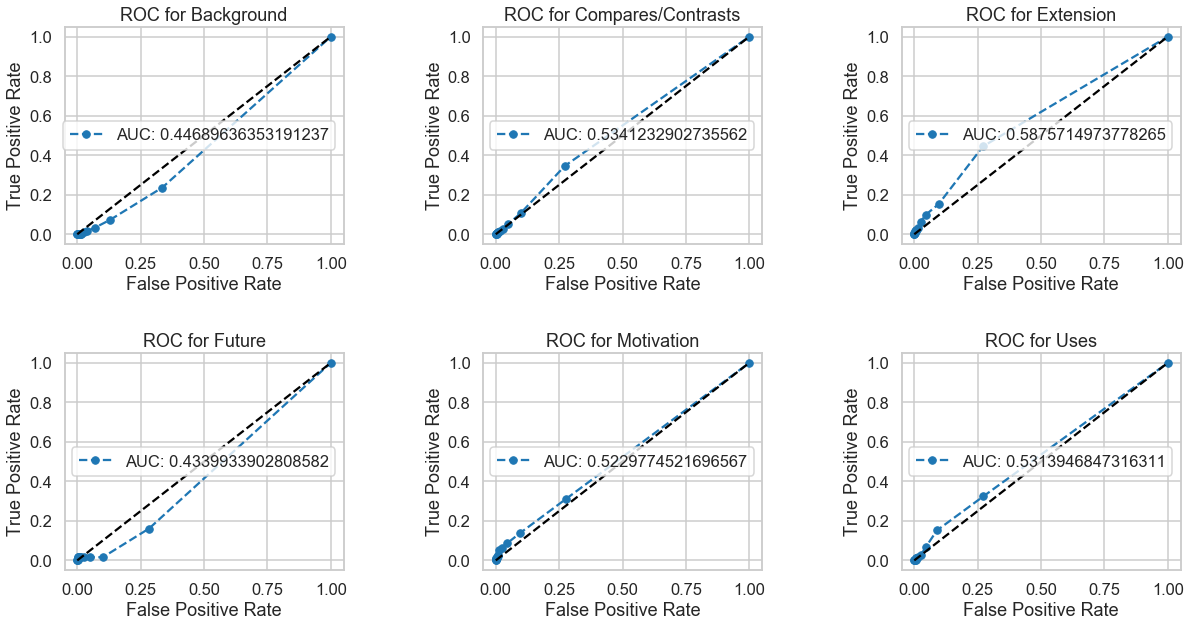

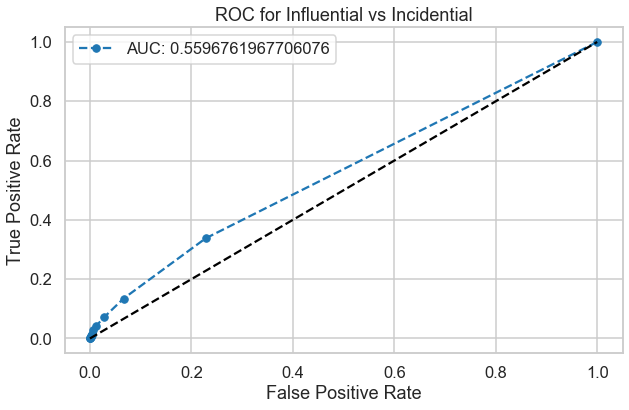

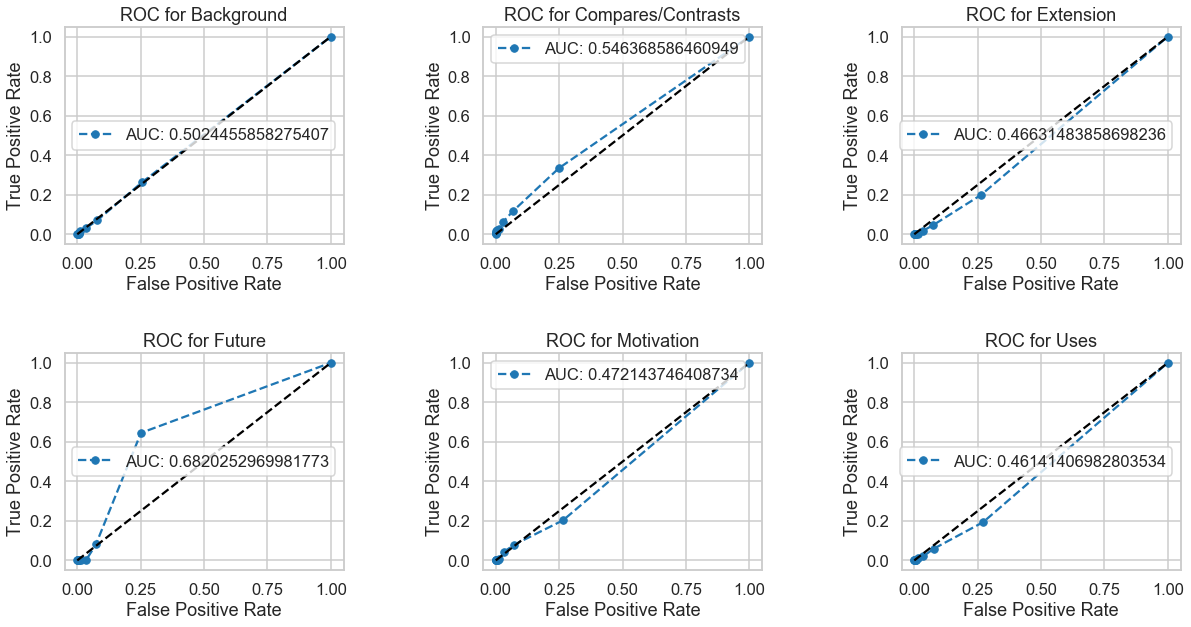

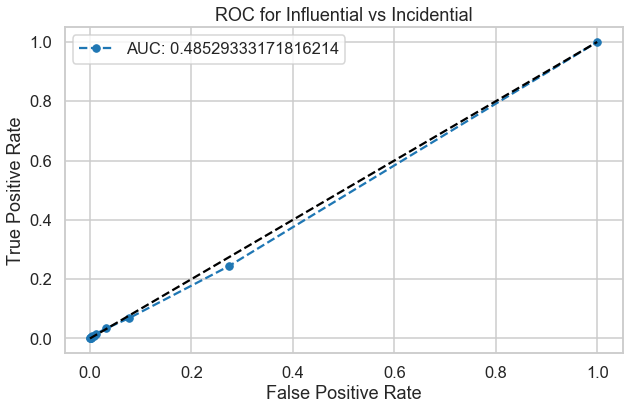

In [32]:
for section in ['introduction', 'method', 'result', 'discussion']:
    multiclass_metrics(df['citation_class_label'], np.repeat(df['num_cit_in_{}'.format(section)].to_numpy().reshape(-1, 1), 6, 1))
    binary_metrics(df['citation_influence_label'], df['num_cit_in_{}'.format(section)])

# Feature 5: Number of different sections a citation occurs

In [33]:
num_sections_cit = []
for idx in df.index:
    cnt = 0
    for section in ['introduction', 'method', 'result', 'discussion']:
        if df['num_cit_in_{}'.format(section)].iloc[idx] > 0:
            cnt += 1
    num_sections_cit.append(cnt)
df['num_sections_cit'] = num_sections_cit

sdp_num_sections_cit = []
for idx in sdp_df.index:
    cnt = 0
    for section in ['introduction', 'method', 'result', 'discussion']:
        if sdp_df['num_cit_in_{}'.format(section)].iloc[idx] > 0:
            cnt += 1
    sdp_num_sections_cit.append(cnt)
sdp_df['num_sections_cit'] = sdp_num_sections_cit

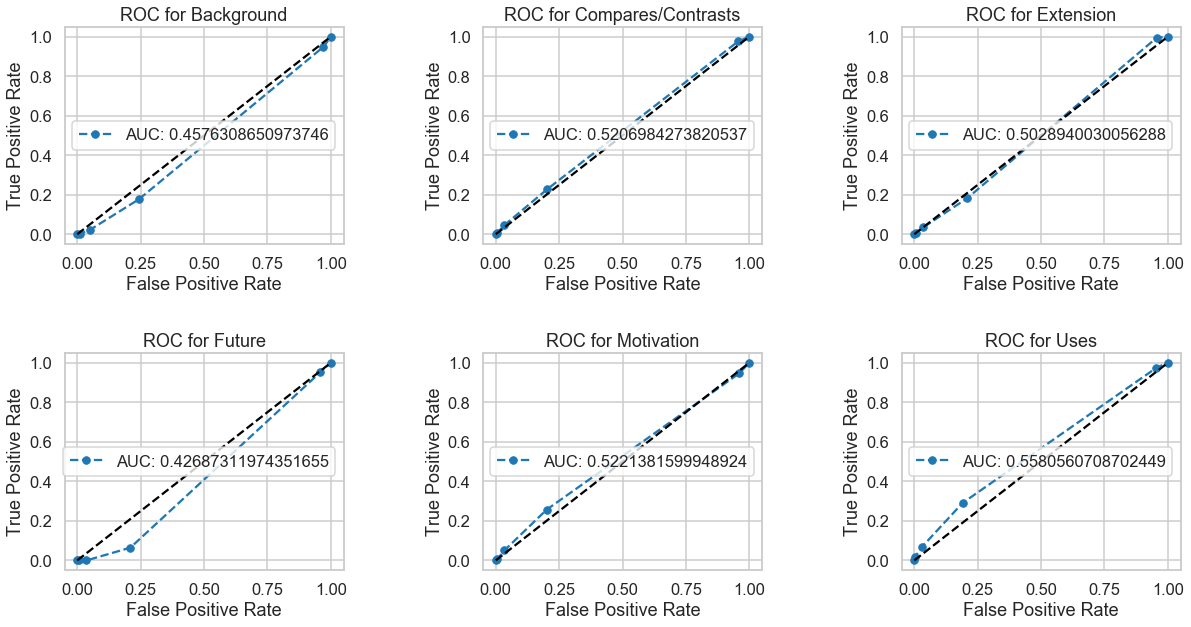

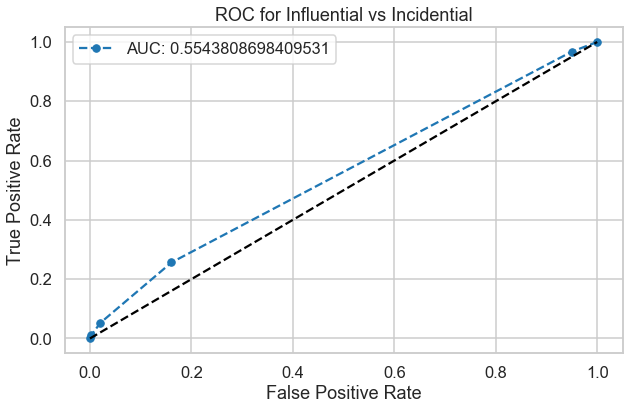

In [34]:
multiclass_metrics(df['citation_class_label'], np.repeat(np.array(df['num_sections_cit']).reshape(-1, 1), 6, 1))
binary_metrics(df['citation_influence_label'], df['num_sections_cit'])

# Feature 6: First location of citation relative to entire paper

In [35]:
first_loc = []
for idx in tqdm(df.index):
    first_loc.append(min(num_citations(idx, df)[1]))
df['first_loc'] = first_loc

sdp_first_loc = []
for idx in tqdm(sdp_df.index):
    sdp_first_loc.append(min(num_citations(idx, sdp_df)[1]))
sdp_df['first_loc'] = sdp_first_loc

100%|██████████| 1000/1000 [00:15<00:00, 64.55it/s]


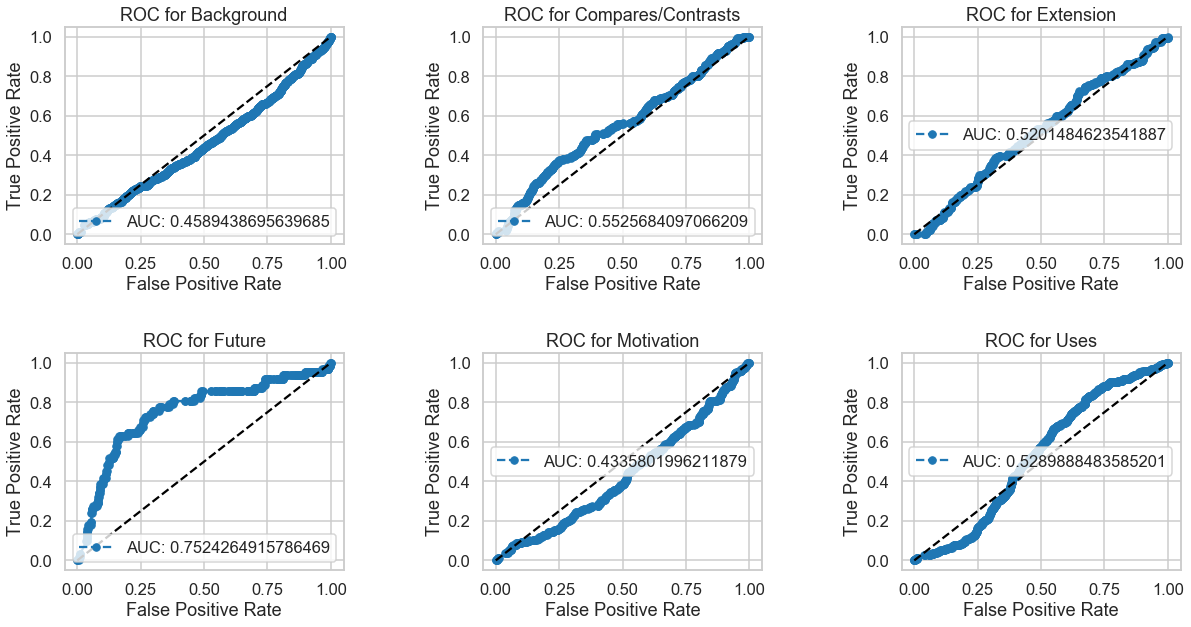

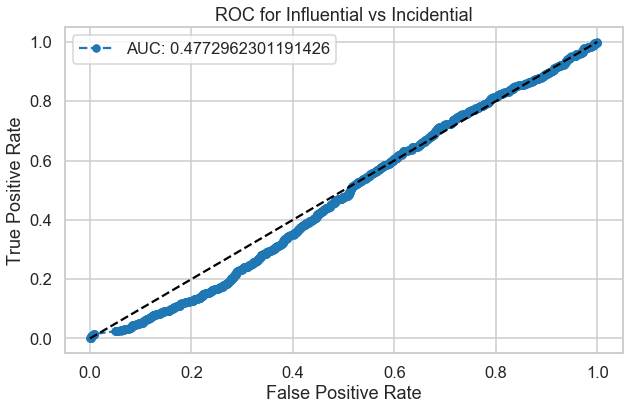

In [36]:
multiclass_metrics(df['citation_class_label'], np.repeat(np.array(df['first_loc']).reshape(-1, 1), 6, 1))
binary_metrics(df['citation_influence_label'], df['first_loc'])

# Export features to csv

In [37]:
df_feat = df.copy()
df_feat = df_feat.drop(columns = ['abstract', 'abstract_percent', 'abstract_length', 'section', 'sent_idx',
                        'percent_in_article', 'percent_in_section', 'num_sections_cit'])
df_feat.to_csv(r'../Dataset/totaldata_features.csv', index = False)

sdp_df_feat = sdp_df.copy()
sdp_df_feat = sdp_df_feat.drop(columns = ['abstract', 'abstract_percent', 'abstract_length', 'section', 'sent_idx',
                        'percent_in_article', 'percent_in_section', 'num_sections_cit'])
sdp_df_feat.to_csv(r'../Dataset/SDP_test_features.csv', index = False)

# Feature 7: Author Overlap

In [46]:
def author_overlap(idx, df, debug = False):
    core_id = df['core_id'].iloc[idx]
    article = process_article(core_id)
    references = article['sections']['reference']['text'].strip()
    
    # Take out "references" from references text
    if references[0:10].upper() == "REFERENCES":
        references = references[11:]
    elif references[0:9].upper() == "REFERENCE":
        references = references[10:]
    
    # Regex references, cited_title, cited_author
    references = re.sub('ﬁ', 'fi', references)
    references = re.sub('ﬂ', 'fl', references)
    references = re.sub('[-‐−–—“”’\;\:\(\)\,\.\?\'\"\/&]', ' ', references)
    references = re.sub('\s+', ' ', references)
    references = re.sub('[^A-Za-z0-9 ]+', '', references)
    # print(references)
    cited_title = re.sub('[-‐−–—\;\:\(\)\,\.\?\'\"\/&]', ' ', df['cited_title'].iloc[idx])
    cited_title = re.sub('\s+', ' ', cited_title)
    cited_title = re.sub('[^A-Za-z0-9 ]+', '', cited_title)
    cited_author = re.sub('[-‐−–—\;\:\(\)\,\.\?\'\"\/&]', ' ', df['cited_author'].iloc[idx])
    cited_author = re.sub('\s+', ' ', cited_author)
    cited_author = re.sub('[^A-Za-z0-9 ]+', '', cited_author)
    
    last_name = df['citing_author'].iloc[idx].split(" ")[1]
    #print(references)
    # print(cited_title)
    #print(cited_author)
    
    # Cited author and title should appear in references
    if references.count(cited_title) == 0:
        if debug:
            print("title not in reference error: {}".format(idx))
        return 0
    elif references.count(cited_author) == 0:
        if debug:
            print("author not in reference error: {}".format(idx))
        return 0
    
    title_pos = [i for i in range(len(references)) if references.startswith(cited_title, i)]
    for tp in title_pos:
        ap = references[:tp].rfind(cited_author)
        if ap == -1:
            continue
        
        if last_name in references[ap:tp]:
            return 1
        else:
            return 0

In [47]:
auth_overlap = []
for idx in tqdm(df.index):
    auth_overlap.append(author_overlap(idx, df))
df['author_overlap'] = auth_overlap

sdp_author_overlap = []
for idx in tqdm(sdp_df.index):
    sdp_author_overlap.append(author_overlap(idx, sdp_df))
sdp_df['author_overlap'] = sdp_author_overlap

100%|██████████| 1000/1000 [00:03<00:00, 300.36it/s]


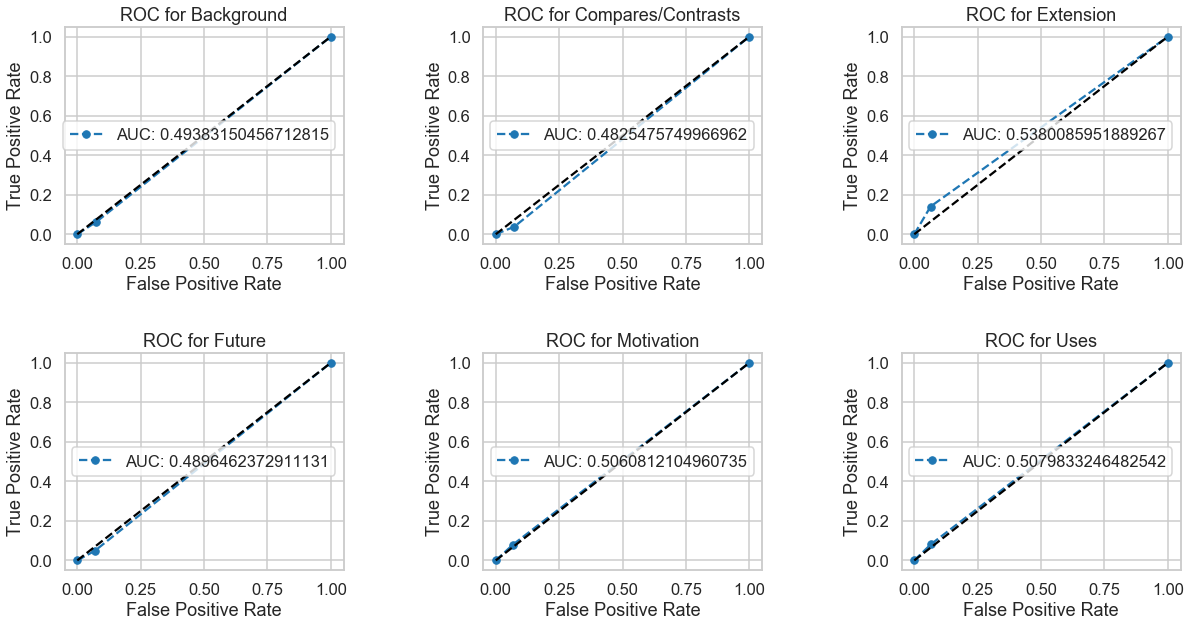

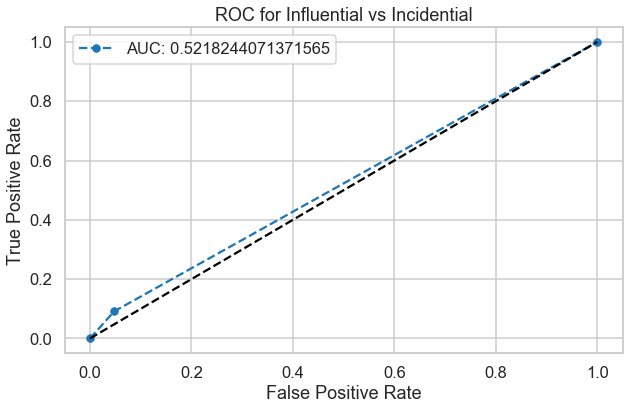

In [48]:
multiclass_metrics(df['citation_class_label'], np.repeat(np.array(df['author_overlap']).reshape(-1, 1), 6, 1))
binary_metrics(df['citation_influence_label'], df['author_overlap'])

# Log of errors:

Errors when running new code on parsed full texts.

Note: when title has a "-", it is removed in the csv. If we replace all "-" in the reference section with " ", then some authors and titles don't show up since their last name is hyphenated. If we also replace all "-" in cited title and author, would also have to replace all "-" in full text. 

1. CC29: csv author should be DeSmet, not Desmet.
2. CC38: author should be HEFCE, title should be Research Excellence ...
3. CC54: csv title should be Basic notions for the analysis of large two-mode networks.
4. CC56: csv title should be Social networks of researchers in B2B marketing a case study of the IMP Group 1984-1999
5. CC60: csv title should be Simultaneously mitigating near-term climate change and improving human health and food security
6. CC62: full text author should be Vaggi
7. CC63: full text author should be Wasserman
8. CC64: csv title should be Studying research collaboration using co-authorships
9. CC67: full text author should be Berthelot. full text title interrupted by footnote. csv title should be Global response of the terrestrial biosphere to CO2 and climate change using a coupled climate-carbon cycle model
10. CC68: full text author should be Bernabo. csv title should be Communication among scientists decision makers and society developing policy-relevant global climate change research
11. CC70: full text should be 2008 instead of 008.
12. CC72: csv title should be Implementation Strategy for the North American Carbon Program Report of the NACP Implementation Strategy Group of the U.S. Carbon Cycle Interagency Working Group
13. CC73: full text author should be Barabasi
14. CC76: csv title should be Scale and cross-scale dynamics governance and information in a multilevel world
15. CC106: csv title should be Kroppskunnskaping—Pasienten som ekspert i helsefremmende prosesser Bodyknowledging Patients as Expert in Health Promotion Processes
16. CC107: csv title should be Kroppskunnskaping—En grunnleggende prosess for mestring ved kronisk sykdom Bodyknowledging—A Basic Process of Coping with Chronic Illness
17. CC108: csv title should be Recovery Following Stroke The Role of Self-Management Education
18. CC109: csv title should be Effectiveness of the Chronic Disease Self-Management Program for Persons with a Serious Mental Illness A Translation Study
19. CC110: csv title should be Evidence Suggesting That a Chronic Disease Self-Management Program Can Improve Health Status While Reducing Hospitalization A Randomized Trial
20. CC111: csv title should be 2009 Self-Management Education Programs by Lay Leaders for People with Chronic Conditions The Cochrane Collaboration
21. CC112: csv title should be Self-Management Education History Definition Outcomes and Mechanisms
22. CC115: csv title should be Strengths-Based Nursing Care Health and Healing for Person and Family
23. CC212: csv title should be Employer Interests in Employee Hours of Work

# Log of csv errors

Errors when checking for location of author + title in references

Note: current reference section might be incorrect, but should all be fixed with new full text.
Note: when other papers are cited in the cited paper, that can screw the references (deal with this edge case)
Note: when cited title is shared in other citations, that also screws with the count. (deal with this edge case)
 
1. CC19: "Springer LOD Conference Portal. Demo paper. In: International Semantic Web Conference" instead of "International Semantic Web Conference" in csv
2. CC50: core_id should be 42702124, not 159766439.
3. CC67: problems in the full text (author is "erthelot, title is "Global response of the terrestrial biosphere to CO2 and climateorks 44 (2016) 226–237change using a coupled climate–carbon cycle model". Will change full text to correct author / title.
4. CC73: "scientiﬁc" instead of "scientific" in full text, name has accented a, which screws things up. will change full text to correct author and title, will edit csv to change author name.
5. CC75: "scientiﬁc" instead of "scientific" in full text. will change full text
6. CC199-CC208: Wrong core_id ????? idk what to do about this. Should we just toss this data entirely?
7. CC224: title should be "Incidence and prevalence of multiple sclerosis in Saskatoon, Saskatchewan", not "Incidence and prevalence of multiple sclerosis in". will change csv.
8. CC358-CC382: titles on new lines. might be screwing things up; otherwise nothing wrong.
9. CC485-CC527: Wrong reference section. Should work with new full text though
10. CC552: don't know what the issue is
11. CC562-CC598: Wrong reference section. Should work with new full text
12. CC686-CC687: Should work with new full text.
13. CC777: Title in common with others.
14. CC818-CC864: Should work with new full ltext
15. CC893: given title is the journal it's published in. changing csv title to "Polyspherical pharmaceuticals: Global psychiatry, capitalism, and space".
16. CC904: Same as above. changing csv title to "Psychopharmaceutical self and imaginary in the social field of psychiatric
treatment"
17. CC975: Full text is interrupted by footnote thingy. will delete from full text.
18. CC985: Title in common with others
19. CC1005: csv title has weird characters. changing csv to match full text.
20. CC1029-CC1056: Should work with new full text
21. CC1100: Note 2. 
22. CC1107: ﬂow instead of flow in full text. will edit full text.
23. CC1125: Title in common with others
24. CC1166: ﬂuctuations instead of fluctuations. will edit full text.
25. CC1169: inﬂuences instead of influences. will edit full text.
26. CC1183: ﬂow instead of flow in full text. will edit full text.
27. CC1186: identiﬁed instead of identified. will edit full text.
28. CC1188: inﬂuences instead of influences. will edit full text.
29. CC1206: Title in common with others
30. CC1261: Unsure
31. CC1276: Full text reference interrupted by footnote. will delete from full text.
32. CC1339: Title in common with others
33. CC1381-CC1382: Should work with new full text.
34. CC1416: Not differentiating title. will edit csv to add " 2012" to title.
35. CC1419-CC1475: Should work with new full text.
36. CC1476: Proﬁling instead of Profiling. will edit full text.
37. CC1477: difﬁcult instead of difficult. will edit full text.
38. CC1479: conﬂict instead of conflict. will edit full text.
39. CC1492: '5 0' instead of '5.0' in csv. will edit csv to replace '5 0' with '50'.
40. CC1596-CC1615: Should work with new full text.
41. CC1626: Title in common with others
42. CC1672: Should work with full text
43. CC1695-CC1706: Should work with full text
44. CC1720-CC1721: Title in common with others
45. CC1751-CC1779: Should work with full text
46. CC1847: Interrupted by footnote. will edit full text.
47. CC1852: Interrupted by footnote. will edit full text.
48. CC1860: Interrupted by footnote. will edit full text.
49. CC1863: signiﬁcance instead of significance. 
50. CC1888: Speciﬁcity instead of Specificity
51. CC1924: inflection
52. CC1961: Title in common
53. CC1965: Title in common
54. CC1977: Title in common
55. CC1995: Title should be "Biological soil crusts of North America", not what is given. will edit csv.
56. CC2011: Title in common. 
57. CC2024-CC2026: Should work with new full text
58. CC2028-CC2059: Should work with new full text
59. CC2166: Title in common
60. CC2167: Interrupted by footnote. will edit full text.
61. CC2174: Title in common
62. CC2193-CC2285: Should work with full text
63. CC2337-CC2347: Should work with full text
64. CC2369-CC2441: Should work with full text
65. CC2442-CC2462: Should work with full text
66. CC2463: Title in csv is wrong. will edit csv to "Transcriptome profiling of developmental and xenobiotic responses in a keystone animal the oligochaete annelid Lumbricus rubellus"
67. CC2464: Title in csv is wrong. will edit csv to "Systems toxicology approach identifies coordinated metabolic responses to copper in a terrestrial non-model invertebrate the earthworm Lumbricus rubellus"
68. CC2505-CC2529: Should work with full text
69. CC2570-CC2582: Should work with full text
70. CC2583-CC2611: Should work with full text
71. CC2613-CC2625: Should work with full text
72. CC2697-CC2705: Should work with full text
73. CC2710-CC2711: Should work with full text
74. CC2712-CC2721: Should work with full text
75. CC2724-CC2727: Should work with full text
76. CC2736: Title in common
77. CC2767-CC2768: Should work with full text
78. CC2779: Should work with full text
79. CC2837: Title in csv is wrong. should be "Ethnography". Will edit csv.
80. CC2845-CC2847: Should work with full text
81. CC2857-CC2911: Should work with full text
82. CC2949: Interrupted by footnote. Will edit full text
83. CC2956: Title in common
84. CC2995: Special character in full text, not in csv. will edit csv. title should be "Wien und die fru¨he Donaukartographie"
85. CC3000: Spaces in title of csv. edit csv title to "Fe2O3" instead of "Fe 2 O 3".

### Log of errors in data

CC50: core_id should be 42702124, not 159766439.

core_id of 12030665, 16229222, 1683841, 19783337, 46115365, 54847651, 56681767, 81719097 don't have 'reference' section. Instead labeled as "Bibliography", "Literature Cited", under "Acknowledgements", or typoed as "eferences". 

CC51: Title doesn't match format in references: 'The First State of the Carbon Cycle Report SOCCR The North American Carbon Budget and Implications for the Global Carbon Cycle National Oceanic and Atmospheric Administration' vs 'The First State of the Carbon Cycle Report (SOCCR): The North American Carbon Budget and Implications for the Global Carbon Cycle. National Oceanic and Atmospheric Administration'

CC53: Title in references has 'fi' special character

CC54: Title in references is "twomode" as opposed to "two mode".

CC57: Same as CC53

CC38: Cited author is "Research", when it should be "HEFCE". 

CC40: The citation context never appears in the paper: "Additionally, studies by #AUTHOR_TAG and [12]  We systematically queried the MAG Evaluate API for each submission using a normalised version of the publication's title (lower case, diacritics removed)" is supposed to be "Additionally, studies by #AUTHOR_TAG and [12] have recently confirmed how comprehensive the MAG citation data are. We could not utilise Google Scholar as it does not oﬀer an API and prohibits ’scraping’ of data. We systematically queried the MAG Evaluate API for each submission using a normalised version of the publication’s title (lower case, diacritics removed)."